In [1]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import tqdm.notebook
import time
from sklearn import preprocessing
import glob
from skimage.measure import block_reduce
import tqdm.notebook
from datetime import datetime
import gc

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('classic')

import src.utils
from src.utils import set_gpytorch_settings
# import GPUtil
set_gpytorch_settings()
# Kernel Imports
from gpytorch.kernels import PeriodicKernel
from src.custom_kernel import MinKernel, AR2Kernel, MaternKernel, LinearKernel
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.constraints import Interval
# from gpytorch.metrics import mean_standardized_log_loss, quantile_coverage_error, mean_squared_error, mean_absolute_error
from src.custom_kernel import noise_lower, noise_upper, noise_init

['/home/dcaos/PycharmProjects/GaussProcesses/notebooks', '/home/dcaos/PycharmProjects/GaussProcesses', '/home/dcaos/anaconda3/lib/python310.zip', '/home/dcaos/anaconda3/lib/python3.10', '/home/dcaos/anaconda3/lib/python3.10/lib-dynload', '', '/home/dcaos/anaconda3/lib/python3.10/site-packages', '/home/dcaos/anaconda3/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '/home/dcaos/anaconda3/lib/python3.10/site-packages/mpmath-1.2.1-py3.10.egg', '/home/dcaos/PycharmProjects/GaussProcesses']


(7642349568, 8353546240)
Before Block Reduce: (174818, 2)
After Block Reduce: (7285, 2)
Number of Nans: 0
Start Time: 2012-09-30 16:55:44
End Time: 2023-02-22 23:25:52
Number of Days: 3642.0416666666665
Time Period (Days): 3797.312592592593


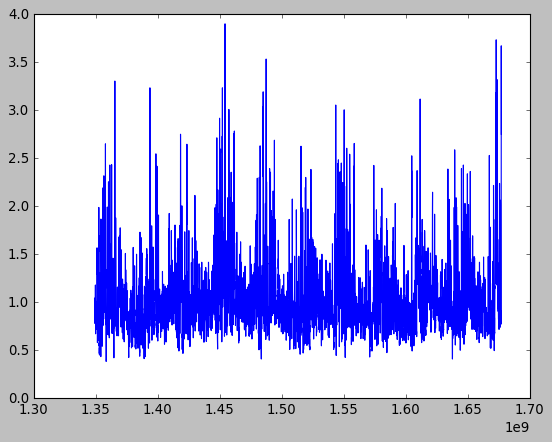

In [2]:
print(torch.cuda.mem_get_info(device=None))
df = pd.read_feather('../Data/feather/46221_9999_wave_height.feather')
# df = pd.read_feather('../data/feather/combined/combined_data.feather')
parameters_wave = ['time', 'wave_height']
parameters_temp = ['time', 'sea_surface_temperature']
df_as_np = df \
    .loc[:, parameters_wave] \
    .astype(float) \
    .replace(to_replace = [999.0, 99.0, 9999.0], value = np.nan) \
    .to_numpy()
using_sk = block_reduce(df_as_np, block_size=(24,1), func=np.mean).astype(float)
plt.plot(using_sk[:-1,0], using_sk[:-1,1])

print(f'Before Block Reduce: {df_as_np.shape}\n'
      f'After Block Reduce: {using_sk.shape}\n'
      f'Number of Nans: {np.count_nonzero(np.isnan(df_as_np))}\n'
      f'Start Time: {datetime.fromtimestamp(df_as_np[0,0])}\n'
      f'End Time: {datetime.fromtimestamp(df_as_np[-1,0])}\n'
      f'Number of Days: {df_as_np.shape[0]/48}\n'
      f'Time Period (Days): {(df_as_np[-1,0] - df_as_np[0,0]) / 24 / 60 / 60}')

In [3]:
X = torch.tensor(using_sk[:-1,0]).float().cuda()#.type(torch.double)
y = torch.tensor(using_sk[:-1,1]).float().cuda()#.type(torch.double)
X = X.reshape(-1,1)
y = y.reshape(-1,1)

X = X[~torch.any(y.isnan(), dim=1)]
y = y[~torch.any(y.isnan(), dim=1)]
y = y.flatten()
X_old = X

In [4]:
X_old

tensor([[1.3491e+09],
        [1.3491e+09],
        [1.3492e+09],
        ...,
        [1.6770e+09],
        [1.6771e+09],
        [1.6771e+09]])

In [5]:
def scaler(a, X_old=X_old, center=True):
    if center is True:
        a = a - X_old.min(0).values
    return a / (X_old.max(0).values - X_old.min(0).values)

def descaler(a, X_old=X_old, center=True):
    if center is True:
        a = a * (X_old.max(0).values - X_old.min(0).values)
    return a + X_old.min(0).values
X = scaler(X, X_old)
y = y.log()



In [6]:
# max and min
scaler_max = X_old.max(0).values.item()
scaler_min = X_old.min(0).values.item()

scale_factor = scaler_max - scaler_min
print(scaler_max, scaler_min, scale_factor)

1677108352.0 1349069952.0 328038400.0


In [7]:
predict_days_out = 14
test_n = 2*predict_days_out
train_x = X[test_n:].contiguous().cuda()
train_y = y[test_n:].contiguous().cuda()
test_x = X[-test_n:].contiguous().cuda()
test_y = y[-test_n:].contiguous().cuda()

In [8]:
# Generate the train_loader and train_dataset
train_loader, train_dataset, test_loader, test_dataset = src.utils.create_train_loader_and_dataset(
    train_x, train_y, test_x, test_y)
data_compact = [train_x, train_y, test_x, test_y, train_loader, train_dataset, test_loader, test_dataset]

In [9]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class StandardApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class MeanFieldApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class MAPApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def make_orthogonal_vs(model, train_x):
    mean_inducing_points = torch.randn(1000, train_x.size(-1), dtype=train_x.dtype, device=train_x.device)
    covar_inducing_points = torch.randn(100, train_x.size(-1), dtype=train_x.dtype, device=train_x.device)

    covar_variational_strategy = gpytorch.variational.VariationalStrategy(
        model, covar_inducing_points,
        gpytorch.variational.CholeskyVariationalDistribution(covar_inducing_points.size(-2)),
        learn_inducing_locations=True
    )

    variational_strategy = gpytorch.variational.OrthogonallyDecoupledVariationalStrategy(
        covar_variational_strategy, mean_inducing_points,
        gpytorch.variational.DeltaVariationalDistribution(mean_inducing_points.size(-2)),
    )
    return variational_strategy

class OrthDecoupledApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points.size(-2))
        variational_strategy = make_orthogonal_vs(self, train_x)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class SpectralDeltaGP(gpytorch.models.ExactGP):
    # def __init__(self, train_x, train_y, kernel, num_deltas, noise_init=None):
    #     likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-11))
    #     likelihood.register_prior("noise_prior", gpytorch.priors.HorseshoePrior(0.1), "noise")
    #     likelihood.noise = 1e-2
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points)
        #variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        #super(SpectralDeltaGP, self).__init__(train_x, train_y, likelihood)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        #base_covar_module = kernel #gpytorch.kernels.SpectralDeltaKernel(num_dims=train_x.size(-1), num_deltas=num_deltas)
        #base_covar_module.initialize_from_data(train_x[0], train_y[0])
        self.covar_module = kernel#gpytorch.kernels.ScaleKernel(base_covar_module)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [10]:
def period_print(x):
  print(f"raw: {x}")
  print(f"seconds: {x * (scale_factor)}")
  print(f"minutes: {x * (scale_factor) / 60}")
  print(f"hours: {x * (scale_factor) / 60 / 60 }")
  print(f"days: {x * (scale_factor) / 60 / 60 / 24}")
  print(f"weeks: {x * (scale_factor) / 60 / 60 / 24 / 7}")
  print(f"months: {x * (scale_factor) / 60 / 60 / 24 / 30}")
  print(f"years: {x * (scale_factor) / 60 / 60 / 24 / 365}")


Mat32 = MaternKernel(nu=1.5)
Mat12 = MaternKernel(nu=0.5)
Mat52 = MaternKernel(nu=2.5)
RBF = RBFKernel()
Per_Week = PeriodicKernel(
    period_length_constraint=Interval(
    # lower_bound=scaler(60*60*24*7, center=False) / 100,
    lower_bound=1e-4, upper_bound=1,
    # upper_bound=scaler(60*60*24*7, center=False) * 100,
    initial_value=scaler(60*60*24*7, center=False))
)
Per_Month = PeriodicKernel(
    period_length_constraint=Interval(
    lower_bound=1e-4, upper_bound=1,
    # lower_bound=scaler(60*60*24*30, center=False) / 100,
    # upper_bound=scaler(60*60*24*30, center=False) * 100,
    initial_value=scaler(60*60*24*30, center=False))
)
Per_Arb = PeriodicKernel()

k_1 = [Mat32, Mat12, RBF, Per_Week, Per_Month, Per_Arb]
k_2 = [*k_1]
k_3 = [*k_1]
kernel_dict = {
    Mat32: 'Mat32',
    Mat12: 'Mat12',  # Very Rough - in continuous time AR(1) process in discrete time
    Mat52: 'Mat52', # Matern 5/2 (Default)
    RBF: 'RBF',
    Per_Week: 'Per_Week',
    Per_Month: 'Per_Month',
    Per_Arb: 'Per_Arb'}
from gpytorch.kernels import RQKernel
RQKernel()

RQKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_alpha_constraint): Positive()
)

In [11]:
# period_print((scaler(60*60*24, center=False) * 1).item())
# period_print((1e-4))

In [12]:
## Kernel Experimentation for periodicity
# kernel = ScaleKernel(PeriodicKernel()) +ScaleKernel(PeriodicKernel()*RBFKernel())  + ScaleKernel(PeriodicKernel()*RBFKernel()) + ScaleKernel(PeriodicKernel()*RBFKernel())
def make_kernel(name_of_kernel):
    if name_of_kernel == 'RBF':
        return RBFKernel()
    elif name_of_kernel.startswith('Mat'):
        nu_value = float(name_of_kernel[-3:])
        return MaternKernel(nu=nu_value)
    if name_of_kernel.startswith('Per'):
        if name_of_kernel == 'Per_Arb':
            return PeriodicKernel()
        elif name_of_kernel == 'Per_Week':
            return PeriodicKernel(
                period_length_constraint=Interval(
                lower_bound=1e-4, upper_bound=1,
                initial_value=scaler(60*60*24*7, center=False)))
        elif name_of_kernel == 'Per_Month':
            return PeriodicKernel(
                period_length_constraint=Interval(
                lower_bound=1e-4, upper_bound=1,
                initial_value=scaler(60*60*24*30, center=False)))
    else:
        raise ValueError('Kernel not found')

# kernel = ScaleKernel(RBFKernel()) + ScaleKernel(Per_Month * RBFKernel())
# kernel_0 = ScaleKernel(RBFKernel()) + ScaleKernel(Per_Week * RBFKernel())
# kernel_1 = ScaleKernel(MaternKernel(nu=2.5)) + ScaleKernel(PeriodicKernel() * RBFKernel())
# kernel_2 = ScaleKernel(MaternKernel(nu=1.5)) + ScaleKernel(PeriodicKernel() * RBFKernel())
# kernel_3 = ScaleKernel(MaternKernel(nu=0.5)) + ScaleKernel(PeriodicKernel() * RBFKernel())

smooth_kernel_list_1 = ['RBF', 'Mat0.5', 'Mat1.5', 'Mat2.5']
smooth_kernel_list_2 = ['RBF', 'Mat0.5', 'Mat1.5', 'Mat2.5']
periodic_kernel_list = ['Per_Arb', 'Per_Week', 'Per_Month']

bic_save = []
index_checker = 0
# try:
for sk1 in smooth_kernel_list_1:
    for sk2 in smooth_kernel_list_2:
        for pk in periodic_kernel_list:
            kernel = ScaleKernel(make_kernel(sk1)) + ScaleKernel(make_kernel(pk) * make_kernel(sk2))
            name_of_kernel = f'{sk1}plus{sk2}x{pk}_exact_gp'
            k_list = [str(sk1), str(pk), str(sk2)]
            exact_gp = src.utils.TrainTestPlotSaveExactGP(
                ExactGPModel, kernel,
                train_x, train_y, test_x, test_y,
                num_iter=1000, lr=0.0063,
                name=name_of_kernel)
            exact_gp.test_eval_exact_gp()
            # exact_gp.plot(show_plot=False)
            bic_value = exact_gp.get_BIC()
            bic_save.append([
                *k_list,
                bic_value.item(),
                kernel.kernels[0].base_kernel.lengthscale.item(),
                kernel.kernels[1].base_kernel.kernels[1].lengthscale.item(),
                kernel.kernels[1].base_kernel.kernels[0].lengthscale.item(),
                kernel.kernels[1].base_kernel.kernels[0].period_length.item()])
            print("Kernel Structure: ", *k_list)
            print("BIC: ", exact_gp.get_BIC().item())
            print("Iterations Number: ",index_checker)
            print("Memory Check: ", torch.cuda.mem_get_info(device=None))
            index_checker += 1
            del exact_gp
            del kernel
            gc.enable()
            gc.collect()
            torch.cuda.empty_cache()
bic_out_df = pd.DataFrame(bic_save, columns=['add_scale1_K1', 'scale2_mult_K2', 'scale2_mult_K3', 'BIC', 's1_ls', 's2_ls', 'pk_ls', 'pk_pr'])
bic_out_df.to_csv('bic_save_linear_kernel_struct.csv')
# except:
#     print("Error")
#     pd.DataFrame(bic_save, columns=['Name', 'BIC', 'Full Kernel', 'Period']).to_csv('bic_save.csv')

            # GPUtil.showUtilization(all=True)


Training_exactGPRBFplusRBFxPer_Arb_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 841.4856567382812 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  RBF Per_Arb RBF
BIC:  -1815.900146484375
Iterations Number:  0
Memory Check:  (4116774912, 8353546240)


Training_exactGPRBFplusRBFxPer_Week_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 9269.203125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  RBF Per_Week RBF
BIC:  -1910.422607421875
Iterations Number:  1
Memory Check:  (4116185088, 8353546240)


Training_exactGPRBFplusRBFxPer_Month_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 24443.84765625 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  RBF Per_Month RBF
BIC:  -2242.749755859375
Iterations Number:  2
Memory Check:  (4174118912, 8353546240)


Training_exactGPRBFplusMat0.5xPer_Arb_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 9094.0029296875 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  RBF Per_Arb Mat0.5
BIC:  -1394.1737060546875
Iterations Number:  3
Memory Check:  (4174708736, 8353546240)


Training_exactGPRBFplusMat0.5xPer_Week_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 16713.28125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 9824.560546875 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  RBF Per_Week Mat0.5
BIC:  -245.5525360107422
Iterations Number:  4
Memory Check:  (4175364096, 8353546240)


Training_exactGPRBFplusMat0.5xPer_Month_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 48759.9453125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 30599.193359375 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  RBF Per_Month Mat0.5
BIC:  -449.04034423828125
Iterations Number:  5
Memory Check:  (4170514432, 8353546240)


Training_exactGPRBFplusMat1.5xPer_Arb_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4824901.5 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 384648.5625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: Numerical

Kernel Structure:  RBF Per_Arb Mat1.5
BIC:  38114764.0
Iterations Number:  6
Memory Check:  (4172611584, 8353546240)


/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 71171.90625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Training_exactGPRBFplusMat1.5xPer_Week_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 130767.4453125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 20525.099609375 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  RBF Per_Week Mat1.5
BIC:  421.194580078125
Iterations Number:  7
Memory Check:  (4172414976, 8353546240)


Training_exactGPRBFplusMat1.5xPer_Month_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 46575.41796875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 20838.34375 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  RBF Per_Month Mat1.5
BIC:  69.50364685058594
Iterations Number:  8
Memory Check:  (4172939264, 8353546240)


Training_exactGPRBFplusMat2.5xPer_Arb_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 10129.6123046875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 12859.4970703125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  RBF Per_Arb Mat2.5
BIC:  -1899.3201904296875
Iterations Number:  9
Memory Check:  (4172480512, 8353546240)


Training_exactGPRBFplusMat2.5xPer_Week_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

Kernel Structure:  RBF Per_Week Mat2.5
BIC:  1511.7332763671875
Iterations Number:  10
Memory Check:  (4172087296, 8353546240)


Training_exactGPRBFplusMat2.5xPer_Month_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 49357.26953125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 13609.4716796875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323:

Kernel Structure:  RBF Per_Month Mat2.5
BIC:  773.9837036132812
Iterations Number:  11
Memory Check:  (4171563008, 8353546240)


Training_exactGPMat0.5plusRBFxPer_Arb_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 24021.537109375 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat0.5 Per_Arb RBF
BIC:  -1248.6121826171875
Iterations Number:  12
Memory Check:  (4172152832, 8353546240)


Training_exactGPMat0.5plusRBFxPer_Week_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1939.3125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 9163.9453125 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat0.5 Per_Week RBF
BIC:  4406.75146484375
Iterations Number:  13
Memory Check:  (4172480512, 8353546240)


Training_exactGPMat0.5plusRBFxPer_Month_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 30890.2109375 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat0.5 Per_Month RBF
BIC:  -1315.8792724609375
Iterations Number:  14
Memory Check:  (4172546048, 8353546240)


Training_exactGPMat0.5plusMat0.5xPer_Arb_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

Kernel Structure:  Mat0.5 Per_Arb Mat0.5
BIC:  -2551.083984375
Iterations Number:  15
Memory Check:  (4173070336, 8353546240)


Training_exactGPMat0.5plusMat0.5xPer_Week_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 6633.17919921875 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat0.5 Per_Week Mat0.5
BIC:  -1305.764404296875
Iterations Number:  16
Memory Check:  (4170645504, 8353546240)


Training_exactGPMat0.5plusMat0.5xPer_Month_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 24736.404296875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 24288.021484375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323:

Kernel Structure:  Mat0.5 Per_Month Mat0.5
BIC:  -862.9265747070312
Iterations Number:  17
Memory Check:  (4170645504, 8353546240)


Training_exactGPMat0.5plusMat1.5xPer_Arb_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 44533.21875 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat0.5 Per_Arb Mat1.5
BIC:  -1390.0506591796875
Iterations Number:  18
Memory Check:  (4170645504, 8353546240)


Training_exactGPMat0.5plusMat1.5xPer_Week_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 54723.1796875 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat0.5 Per_Week Mat1.5
BIC:  -1284.9490966796875
Iterations Number:  19
Memory Check:  (4170121216, 8353546240)


Training_exactGPMat0.5plusMat1.5xPer_Month_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 26033.509765625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 20987.6875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: Nume

Kernel Structure:  Mat0.5 Per_Month Mat1.5
BIC:  -57.435325622558594
Iterations Number:  20
Memory Check:  (4129226752, 8353546240)


Training_exactGPMat0.5plusMat2.5xPer_Arb_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 436961.84375 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat0.5 Per_Arb Mat2.5
BIC:  -1784.057373046875
Iterations Number:  21
Memory Check:  (3813801984, 8353546240)


Training_exactGPMat0.5plusMat2.5xPer_Week_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 63842.3515625 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat0.5 Per_Week Mat2.5
BIC:  -1182.9886474609375
Iterations Number:  22
Memory Check:  (3800891392, 8353546240)


Training_exactGPMat0.5plusMat2.5xPer_Month_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 47281.796875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 519622.09375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: Numer

Kernel Structure:  Mat0.5 Per_Month Mat2.5
BIC:  -684.656494140625
Iterations Number:  23
Memory Check:  (3976921088, 8353546240)


Training_exactGPMat1.5plusRBFxPer_Arb_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 160896.453125 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat1.5 Per_Arb RBF
BIC:  3008.748291015625
Iterations Number:  24
Memory Check:  (3929079808, 8353546240)


Training_exactGPMat1.5plusRBFxPer_Week_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 18966.76953125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 13492.5771484375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323:

Kernel Structure:  Mat1.5 Per_Week RBF
BIC:  4658.58544921875
Iterations Number:  25
Memory Check:  (3957325824, 8353546240)


Training_exactGPMat1.5plusRBFxPer_Month_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 248267.078125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 41740.5625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: Numeri

Kernel Structure:  Mat1.5 Per_Month RBF
BIC:  2271.631103515625
Iterations Number:  26
Memory Check:  (3589210112, 8353546240)


Training_exactGPMat1.5plusMat0.5xPer_Arb_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 24652.650390625 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat1.5 Per_Arb Mat0.5
BIC:  -1683.451904296875
Iterations Number:  27
Memory Check:  (3575185408, 8353546240)


Training_exactGPMat1.5plusMat0.5xPer_Week_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 20540.822265625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 43495.19921875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: 

Kernel Structure:  Mat1.5 Per_Week Mat0.5
BIC:  -358.19317626953125
Iterations Number:  28
Memory Check:  (3842899968, 8353546240)


Training_exactGPMat1.5plusMat0.5xPer_Month_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 25498.09765625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 34588.43359375 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat1.5 Per_Month Mat0.5
BIC:  -498.749755859375
Iterations Number:  29
Memory Check:  (3591700480, 8353546240)


Training_exactGPMat1.5plusMat1.5xPer_Arb_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 80423.9140625 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat1.5 Per_Arb Mat1.5
BIC:  2790.686767578125
Iterations Number:  30
Memory Check:  (3626631168, 8353546240)


Training_exactGPMat1.5plusMat1.5xPer_Week_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 80077.3515625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 23741.306640625 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat1.5 Per_Week Mat1.5
BIC:  1937.2269287109375
Iterations Number:  31
Memory Check:  (3438870528, 8353546240)


Training_exactGPMat1.5plusMat1.5xPer_Month_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 99477.4921875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 37039.38671875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: Nu

Kernel Structure:  Mat1.5 Per_Month Mat1.5
BIC:  1323.915283203125
Iterations Number:  32
Memory Check:  (3494969344, 8353546240)


Training_exactGPMat1.5plusMat2.5xPer_Arb_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 297267.65625 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat1.5 Per_Arb Mat2.5
BIC:  2597.76123046875
Iterations Number:  33
Memory Check:  (3407347712, 8353546240)


Training_exactGPMat1.5plusMat2.5xPer_Week_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 110715.4375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 91545.0703125 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat1.5 Per_Week Mat2.5
BIC:  1588.5335693359375
Iterations Number:  34
Memory Check:  (3405316096, 8353546240)


Training_exactGPMat1.5plusMat2.5xPer_Month_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 48927.1875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 99365.6640625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: Numeri

Kernel Structure:  Mat1.5 Per_Month Mat2.5
BIC:  1277.1741943359375
Iterations Number:  35
Memory Check:  (3374448640, 8353546240)


Training_exactGPMat2.5plusRBFxPer_Arb_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

Kernel Structure:  Mat2.5 Per_Arb RBF
BIC:  450.315673828125
Iterations Number:  36
Memory Check:  (3356098560, 8353546240)


Training_exactGPMat2.5plusRBFxPer_Week_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 20873.123046875 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat2.5 Per_Week RBF
BIC:  374.224365234375
Iterations Number:  37
Memory Check:  (3434872832, 8353546240)


Training_exactGPMat2.5plusRBFxPer_Month_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 36263.59375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 92126.6640625 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat2.5 Per_Month RBF
BIC:  1067.511962890625
Iterations Number:  38
Memory Check:  (3376218112, 8353546240)


Training_exactGPMat2.5plusMat0.5xPer_Arb_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 18308.353515625 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat2.5 Per_Arb Mat0.5
BIC:  -1221.6102294921875
Iterations Number:  39
Memory Check:  (3375759360, 8353546240)


Training_exactGPMat2.5plusMat0.5xPer_Week_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 32310.099609375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 20072.943359375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323:

Kernel Structure:  Mat2.5 Per_Week Mat0.5
BIC:  -579.552490234375
Iterations Number:  40
Memory Check:  (3318743040, 8353546240)


Training_exactGPMat2.5plusMat0.5xPer_Month_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 70604.546875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 34711.37109375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: Num

Kernel Structure:  Mat2.5 Per_Month Mat0.5
BIC:  -278.22442626953125
Iterations Number:  41
Memory Check:  (3314221056, 8353546240)


Training_exactGPMat2.5plusMat1.5xPer_Arb_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 411795.1875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 100628.0625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: Numeric

Kernel Structure:  Mat2.5 Per_Arb Mat1.5
BIC:  1644.164306640625
Iterations Number:  42
Memory Check:  (3257204736, 8353546240)


Training_exactGPMat2.5plusMat1.5xPer_Week_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 28352.154296875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 380144.40625 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat2.5 Per_Week Mat1.5
BIC:  819.5017700195312
Iterations Number:  43
Memory Check:  (3188326400, 8353546240)


Training_exactGPMat2.5plusMat1.5xPer_Month_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 38152.0703125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 32231.486328125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: N

Kernel Structure:  Mat2.5 Per_Month Mat1.5
BIC:  594.460205078125
Iterations Number:  44
Memory Check:  (3106734080, 8353546240)


Training_exactGPMat2.5plusMat2.5xPer_Arb_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2271.7919921875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Kernel Structure:  Mat2.5 Per_Arb Mat2.5
BIC:  -2012.3992919921875
Iterations Number:  45
Memory Check:  (3113746432, 8353546240)


Training_exactGPMat2.5plusMat2.5xPer_Week_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 323038.90625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 44224.29296875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: Num

Kernel Structure:  Mat2.5 Per_Week Mat2.5
BIC:  1093.0355224609375
Iterations Number:  46
Memory Check:  (3118792704, 8353546240)


Training_exactGPMat2.5plusMat2.5xPer_Month_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 91560.7734375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 34201.0625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dcaos/anaconda3/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: Numeri

Kernel Structure:  Mat2.5 Per_Month Mat2.5
BIC:  1539.3577880859375
Iterations Number:  47
Memory Check:  (3000696832, 8353546240)


In [13]:
# bic_out_df = pd.DataFrame(bic_save, columns=['Name1', 'Name2', 'Name3', 'BIC', 's1_ls', 's2_ls', 'pk_ls', 'pk_pr'])
# bic_out_df.to_csv('bic_save_2.csv')
# bic_out_df['BIC'].min()
# def period_print(x):
#   print(f"raw: {x}")
#   print(f"seconds: {x * (scale_factor)}")
#   print(f"minutes: {x * (scale_factor) / 60}")
#   print(f"hours: {x * (scale_factor) / 60 / 60 }")
#   print(f"days: {x * (scale_factor) / 60 / 60 / 24}")
#   print(f"weeks: {x * (scale_factor) / 60 / 60 / 24 / 7}")
#   print(f"months: {x * (scale_factor) / 60 / 60 / 24 / 30}")
#   print(f"years: {x * (scale_factor) / 60 / 60 / 24 / 365}")

In [14]:
bic_out_df
# print(bic_save)
# for i in bic_save:
#     period_print(i[-1].item(), "\n------------------")
# kernel.kernels[-1].base_kernel.kernels[0].period_length
# period_print(scaler(60*60*24, center=False).item())

,add_scale1_K1,scale2_mult_K2,scale2_mult_K3,BIC,s1_ls,s2_ls,pk_ls,pk_pr
0,RBF,Per_Arb,RBF,-1805.135620,2.833134,0.087118,0.000075,0.220226
1,RBF,Per_Week,RBF,-1827.237061,0.000386,2.457447,2.792247,0.001583
2,RBF,Per_Month,RBF,-2233.627686,0.000293,0.254716,2.288955,0.008738
3,RBF,Per_Arb,Mat0.5,-1298.525146,1.319847,0.032006,1.491903,1.482382
4,RBF,Per_Week,Mat0.5,-322.171631,1.600245,0.057973,4.177843,0.002056
5,RBF,Per_Month,Mat0.5,-392.073547,1.264017,0.058467,0.198392,0.011295
6,RBF,Per_Arb,Mat1.5,1953.407471,1.762203,0.010063,0.102558,0.073804
7,RBF,Per_Week,Mat1.5,509.828369,1.546903,0.011549,4.772974,0.002417
8,RBF,Per_Month,Mat1.5,47.187729,1.462433,0.016194,0.226457,0.008751
9,RBF,Per_Arb,Mat2.5,-1908.702881,3.312636,0.032085,0.000478,0.109313


In [60]:
def period_convert(x, type_to_convert):
    match type_to_convert:
        case "raw":
            return x
        case "seconds":
            return x * scale_factor
        case "minutes":
            return x * scale_factor / 60
        case "hours":
            return x * scale_factor / 60 / 60
        case "days":
            return x * scale_factor / 60 / 60 / 24
        case "weeks":
            return x * scale_factor / 60 / 60 / 24 / 7
        case "months":
            return x * scale_factor / 60 / 60 / 24 / 30
        case "years":
            return x * scale_factor / 60 / 60 / 24 / 365
converted_array = []
for index, row in bic_out_df.iterrows():
    converted_array.append(
        [f'Scale({row["add_scale1_K1"]})+Scale({row["scale2_mult_K2"]}*{row["scale2_mult_K3"]})', #row['BIC'],
        period_convert(row['s1_ls'], "days"),
        period_convert(row['s2_ls'], "days"),
        period_convert(row['pk_ls'], "days"),
        period_convert(row['pk_pr'],"days")])

df_with_converstions = pd.DataFrame(
    converted_array,
    columns=[
        "Kernel", "Length_Scale_for_smoothing_term_1 (Days)",
        "Length_Scale_for_smoothing_term_2 (Days)", "Length_Scale_for_periodic_term_2 (Days)","Period_Length_for_periodic_term_2 (Days)"])
joined_bic_table = pd.concat([df_with_converstions, bic_out_df], axis=1)
joined_bic_table

,Kernel,Length_Scale_for_smoothing_term_1 (Days),Length_Scale_for_smoothing_term_2 (Days),Length_Scale_for_periodic_term_2 (Days),Period_Length_for_periodic_term_2 (Days),add_scale1_K1,scale2_mult_K2,scale2_mult_K3,BIC,s1_ls,s2_ls,pk_ls,pk_pr
0,Scale(RBF)+Scale(Per_Arb*RBF),10756.675944,330.764572,0.285057,836.139177,RBF,Per_Arb,RBF,-1805.135620,2.833134,0.087118,0.000075,0.220226
1,Scale(RBF)+Scale(Per_Week*RBF),1.464003,9330.289341,10601.436349,6.010267,RBF,Per_Week,RBF,-1827.237061,0.000386,2.457447,2.792247,0.001583
2,Scale(RBF)+Scale(Per_Month*RBF),1.112530,967.088725,8690.569506,33.176087,RBF,Per_Month,RBF,-2233.627686,0.000293,0.254716,2.288955,0.008738
3,Scale(RBF)+Scale(Per_Arb*Mat0.5),5011.118188,121.518015,5664.370060,5628.218547,RBF,Per_Arb,Mat0.5,-1298.525146,1.319847,0.032006,1.491903,1.482382
4,Scale(RBF)+Scale(Per_Week*Mat0.5),6075.714930,220.108936,15862.187083,7.807146,RBF,Per_Week,Mat0.5,-322.171631,1.600245,0.057973,4.177843,0.002056
5,Scale(RBF)+Scale(Per_Month*Mat0.5),4799.144787,221.984807,753.243117,42.885764,RBF,Per_Month,Mat0.5,-392.073547,1.264017,0.058467,0.198392,0.011295
6,Scale(RBF)+Scale(Per_Arb*Mat1.5),6690.627841,38.207175,389.385691,280.212866,RBF,Per_Arb,Mat1.5,1953.407471,1.762203,0.010063,0.102558,0.073804
7,Scale(RBF)+Scale(Per_Week*Mat1.5),5873.190601,43.846995,18121.744895,9.177903,RBF,Per_Week,Mat1.5,509.828369,1.546903,0.011549,4.772974,0.002417
8,Scale(RBF)+Scale(Per_Month*Mat1.5),5552.480236,61.485172,859.797272,33.225813,RBF,Per_Month,Mat1.5,47.187729,1.462433,0.016194,0.226457,0.008751
9,Scale(RBF)+Scale(Per_Arb*Mat2.5),12577.218770,121.817838,1.816306,415.032993,RBF,Per_Arb,Mat2.5,-1908.702881,3.312636,0.032085,0.000478,0.109313


In [63]:
# print(joined_bic_table.groupby("add_scale1_K1").mean())
# print(joined_bic_table.groupby("scale2_mult_K2").mean())
# print(joined_bic_table.groupby("scale2_mult_K3").mean())
joined_bic_table.groupby(['BIC','add_scale1_K1']).min(['BIC'])
joined_bic_table.groupby(['BIC','scale2_mult_K2']).min(['BIC'])
joined_bic_table.groupby(['BIC','scale2_mult_K3']).min(['BIC'])
joined_bic_table.loc[joined_bic_table['scale2_mult_K2']=="Per_Month"].groupby(['BIC','add_scale1_K1','scale2_mult_K2', 'scale2_mult_K3']).min(['BIC'])

,,,,Length_Scale_for_smoothing_term_1 (Days),Length_Scale_for_smoothing_term_2 (Days),Length_Scale_for_periodic_term_2 (Days),Period_Length_for_periodic_term_2 (Days),s1_ls,s2_ls,pk_ls,pk_pr
BIC,add_scale1_K1,scale2_mult_K2,scale2_mult_K3,,,,,,,,
-2233.627686,RBF,Per_Month,RBF,1.112530,967.088725,8690.569506,33.176087,0.000293,0.254716,2.288955,0.008738
-1367.811768,Mat0.5,Per_Month,RBF,134.351948,4568.363313,5968.643105,32.884873,0.035386,1.203233,1.572044,0.008661
-757.242493,Mat0.5,Per_Month,Mat0.5,487.166801,187.401082,1592.437050,28.933439,0.128312,0.049358,0.419422,0.007621
-707.888000,Mat0.5,Per_Month,Mat2.5,129.431518,121.941032,683.594912,32.162813,0.034090,0.032117,0.180048,0.008471
-516.528564,Mat1.5,Per_Month,Mat0.5,2285.668017,186.759314,1841.134398,30.105351,0.602008,0.049189,0.484925,0.007929
-402.086670,Mat2.5,Per_Month,Mat0.5,2107.770475,168.318785,1302.464115,28.611561,0.555153,0.044332,0.343048,0.007536
-392.073547,RBF,Per_Month,Mat0.5,4799.144787,221.984807,753.243117,42.885764,1.264017,0.058467,0.198392,0.011295
-296.835205,Mat0.5,Per_Month,Mat1.5,136.946248,60.261670,2558.416096,18.831912,0.036069,0.015872,0.673845,0.004960
47.187729,RBF,Per_Month,Mat1.5,5552.480236,61.485172,859.797272,33.225813,1.462433,0.016194,0.226457,0.008751


In [62]:
joined_bic_table.groupby(['BIC','add_scale1_K1','scale2_mult_K2', 'scale2_mult_K3']).min(['BIC'])

,,,,Length_Scale_for_smoothing_term_1 (Days),Length_Scale_for_smoothing_term_2 (Days),Length_Scale_for_periodic_term_2 (Days),Period_Length_for_periodic_term_2 (Days),s1_ls,s2_ls,pk_ls,pk_pr
BIC,add_scale1_K1,scale2_mult_K2,scale2_mult_K3,,,,,,,,
-2421.545898,Mat0.5,Per_Arb,Mat0.5,231.530807,322.315168,5459.851998,5454.527984,0.060981,0.084893,1.438037,1.436634
-2233.627686,RBF,Per_Month,RBF,1.112530,967.088725,8690.569506,33.176087,0.000293,0.254716,2.288955,0.008738
-2027.209717,Mat2.5,Per_Arb,Mat2.5,13981.388718,130.175972,1.786906,307.682334,3.682471,0.034286,0.000471,0.081039
-1908.702881,RBF,Per_Arb,Mat2.5,12577.218770,121.817838,1.816306,415.032993,3.312636,0.032085,0.000478,0.109313
-1827.237061,RBF,Per_Week,RBF,1.464003,9330.289341,10601.436349,6.010267,0.000386,2.457447,2.792247,0.001583
-1805.135620,RBF,Per_Arb,RBF,10756.675944,330.764572,0.285057,836.139177,2.833134,0.087118,0.000075,0.220226
-1798.739136,Mat0.5,Per_Arb,Mat2.5,143.284935,2824.744853,5700.281691,5449.201708,0.037739,0.743992,1.501362,1.435231
-1734.705811,Mat1.5,Per_Arb,Mat0.5,3030.710125,105.029607,5973.878408,5926.803683,0.798240,0.027663,1.573423,1.561024
-1713.608154,Mat0.5,Per_Arb,RBF,127.506101,3831.431239,4244.671627,4398.272332,0.033583,1.009137,1.117978,1.158434


In [15]:
# # Lengthscale for first smoothing kernel
# print(bic_save[-1][2].kernels[0].base_kernel.lengthscale.item())
# # Lengthscale for second smoothing kernel inside the product
# print(bic_save[-1][2].kernels[1].base_kernel.kernels[1].lengthscale.item())
# # Lengthscale and Period for periodic kernel inside the product
# print(bic_save[-1][2].kernels[1].base_kernel.kernels[0].period_length.item())
# print(bic_save[-1][2].kernels[1].base_kernel.kernels[0].lengthscale.item())
# print(bic_save[-1][0])
# new_bic_save = []
# for i in bic_save:
#     name = i[0]
#     bic = i[1].item()
#     s1_ls = i[2].kernels[0].base_kernel.lengthscale.item()
#     s2_ls = i[2].kernels[1].base_kernel.kernels[1].lengthscale.item()
#     pk_ls = i[2].kernels[1].base_kernel.kernels[0].lengthscale.item()
#     pk_pr = i[2].kernels[1].base_kernel.kernels[0].period_length.item()
#     new_bic_save.append([name, bic, s1_ls, s2_ls, pk_ls, pk_pr])
# new_bic_save_df = pd.DataFrame(
#     new_bic_save, columns=['Name', 'BIC', 's1_ls', 's2_ls', 'pk_ls', 'pk_pr'])
# new_bic_save_df.to_csv('new_bic_save.csv')
# new_bic_save_df



In [16]:
# # kernel = ScaleKernel(RBFKernel()) + ScaleKernel(MaternKernel()) + ScaleKernel(PeriodicKernel())
# kernel = ScaleKernel(RBFKernel() * RBFKernel()) + ScaleKernel(PeriodicKernel() * MaternKernel()) + ScaleKernel(PeriodicKernel() * RBFKernel()) + ScaleKernel(PeriodicKernel() * RBFKernel())
# # kernel = ScaleKernel(RBFKernel()) #+ ScaleKernel(MaternKernel()) + ScaleKernel(PeriodicKernel())
# kernel = ScaleKernel(MaternKernel(nu=0.5))
#
#
#
# results = []
# # for i in range(150, 200):
# exact_gp = src.utils.TrainTestPlotSaveExactGP(
#     ExactGPModel, kernel,
#     train_x, train_y, test_x, test_y, num_iter=250,
#     name=f'_Mat_RBF')
# exact_gp.test_eval_exact_gp()
# exact_gp.plot()
# bic = exact_gp.get_BIC()
# print(bic, kernel)
# results.append([bic, kernel])
# # del exact_gp
# # print(f'BIC: {exact_gp.get_BIC()}')
# # print(f'AVG Error: {error}')

In [17]:
# torch.cuda.mem_get_info(device=None)
# exact_gp.plot(set_x_limit=(.992,1))#, set_y_limit=(0,4))

In [18]:
# print(exact_gp.get_BIC())
# del exact_gp


In [19]:
## Test all combinations of kernels

# for i in k_1:
#     for j in k_2:
#         for z in k_3:
#             kernel = (
#                 ScaleKernel(i) +
#                 ScaleKernel(j) +
#                 ScaleKernel(z))
#             exact_gp = src.utils.TrainTestPlotSaveExactGP(
#                 ExactGPModel, kernel,
#                 train_x, train_y, test_x, test_y,
#                 name=f'{str(kernel_dict[i])}{str(kernel_dict[j])}{str(kernel_dict[z])}')
#             exact_gp.test_eval_exact_gp()